# LSTM Model

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle
import datetime as dt
import numpy as np
from dateutil.parser import *
from dateutil import tz
import pytz
import plotly.graph_objects as go
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,GRU,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from IPython.display import Image

import warnings

warnings.filterwarnings('ignore')



In [21]:
#getting the pkl file name of certain pair
def get_his_data_filename(pair, granularity,time_from = None, time_to = None):
    
    if time_from:
        # if we want to include time in the file name
        return f"downloaded data/{pair}_{granularity}_{time_from}_{time_to}.pkl"
        
    else:
        return f"downloaded data/{pair}_{granularity}.pkl"

# change timezone from string to timestamp
def parser(row):
    d= parse(row)
    return d

# change timezone to sg
def astimezone(row):
    return row.astimezone(pytz.timezone('Singapore'))

#convert any date string with dateutil and then put a tz at the back as oanda timezone is utc
def get_utc_dt_from_string(date_str):
    d = parse(date_str)
    return d.replace(tzinfo=dt.timezone.utc)

In [22]:
#getting minute candles

xau_usd_M1_2015_042822 = pd.read_pickle('./datasets/xau_usd_M1_2015_042822_sg.pkl')


In [23]:
#inputting candles df for each event into events df

event_df = pd.read_pickle('./datasets/ff_event_df_010115_033122.pkl')

#keeping only 1 event per datetime

event_df = event_df.loc[event_df['event_date_time'].drop_duplicates(keep='first').index]

event_df['candles']= 0

event_df['candles'] = event_df['candles'].astype('object')

drop_event = []
for i in event_df.index:
    try:
        index = xau_usd_M1_2015_042822[xau_usd_M1_2015_042822['time'] == event_df.loc[i]['event_date_time']].index[0]-1
        event_df['candles'][i] = xau_usd_M1_2015_042822.loc[index:(index+28800)]
    except:
        drop_event.append(i)
        
event_df = event_df.drop(drop_event,axis=0)
event_df.reset_index(inplace=True,drop=True)

event_df

,day_of_week,event_date_time,event_time_holder,curr,impact,event,previous,forecast,actual,candles
0,Fri,2015-01-02 23:00:00+08:00,15:00,USD,high,ISM Manufacturing PMI,58.7,57.6,55.5,time volume mi...
1,Mon,2015-01-05 21:00:00+08:00,13:00,USD,medium,FOMC Member Williams Speaks,,,,time volume mi...
2,Tue,2015-01-06 23:00:00+08:00,15:00,USD,high,ISM Services PMI,59.3,58.2,56.2,time volume mi...
3,Wed,2015-01-07 21:15:00+08:00,13:15,USD,high,ADP Non-Farm Employment Change,227K,227K,241K,time volume mi...
4,Wed,2015-01-07 21:30:00+08:00,13:30,USD,high,Trade Balance,-42.2B,-42.3B,-39.0B,time volume mi...
...,...,...,...,...,...,...,...,...,...,...
3033,Tue,2022-03-29 22:00:00+08:00,15:00,USD,high,JOLTS Job Openings,11.28M,11.00M,11.27M,time volume ...
3034,Wed,2022-03-30 20:15:00+08:00,13:15,USD,high,ADP Non-Farm Employment Change,486K,455K,455K,time volume ...
3035,Wed,2022-03-30 20:30:00+08:00,13:30,USD,medium,Final GDP q/q,7.0%,7.0%,6.9%,time volume ...
3036,Wed,2022-03-30 22:30:00+08:00,15:30,USD,medium,Crude Oil Inventories,-2.5M,-2.0M,-3.4M,time volume ...


Our previous models trying to trade the volatility immediately after each event have not been very fuitful. We will now build a LSTM model, where we try to model how price moves a few minutes after the event. The candles which we will fit to train the model will be 10 candles, consisting of 1 candle directly before the event happens, and 9 candles after. We will then predict the 11th candle. The reason why we take 1 candle before the event is so that our model captures the price jump before the event and immediately after the event. Hence, for example, if the event were to happen at 9pm, we expect the price to jump at 9pm as compared to 8:59m. 

We will therefore use candles from 8:59pm to 9:09pm to predict the closing price candle at 9:10pm. Our goal is to enter the trade at 9:10:01pm, and if our prediction is correct, it will hit the target price, which is the closing price at 9:10pm.

In [24]:
# preparing data to fit into lstm model
lstm_x_df = pd.DataFrame(np.array(event_df['candles'][0][:10]['mid_c']).reshape(1,-1))
lstm_y_df = pd.Series(event_df['candles'][0].iloc[10]['mid_c'])

for i in range(1,len(event_df)):
    if event_df['candles'][i].shape[0]>10:
        lstm_x_df = pd.concat([lstm_x_df,pd.DataFrame(np.array(event_df['candles'][i][:10]['mid_c']).reshape(1,-1))])
        lstm_y_df = pd.concat([lstm_y_df,pd.Series(event_df['candles'][i].iloc[10]['mid_c'])])

lstm_columns = []
for i in range(10):
    column_name = 'timestep_' + str(i)
    lstm_columns.append(column_name)
    
lstm_x_df.columns = lstm_columns

lstm_x_df

,timestep_0,timestep_1,timestep_2,timestep_3,timestep_4,timestep_5,timestep_6,timestep_7,timestep_8,timestep_9
0,1171.736,1173.208,1172.455,1173.020,1172.374,1171.938,1172.243,1171.950,1171.975,1171.946
0,1189.229,1188.618,1187.956,1187.522,1188.976,1188.863,1188.164,1187.980,1188.016,1188.330
0,1210.108,1211.356,1212.756,1211.396,1211.958,1211.631,1211.278,1211.142,1211.778,1211.281
0,1212.779,1209.970,1211.040,1212.530,1212.380,1212.412,1212.105,1211.550,1211.831,1211.220
0,1210.618,1209.872,1209.320,1210.381,1210.612,1210.554,1211.092,1210.484,1211.273,1211.828
...,...,...,...,...,...,...,...,...,...,...
0,1907.530,1906.386,1912.375,1910.245,1910.430,1910.010,1912.840,1911.260,1910.530,1910.856
0,1927.330,1928.265,1930.155,1929.880,1929.285,1929.900,1928.620,1929.265,1928.560,1928.520
0,1928.330,1928.405,1928.290,1927.820,1928.520,1928.495,1929.580,1927.060,1925.990,1926.195
0,1933.770,1933.415,1933.304,1932.940,1934.516,1935.790,1936.010,1935.980,1934.830,1934.610


In [25]:
test_size = 0.1
test_len = round(test_size*len(lstm_x_df))
train_len = len(lstm_x_df) - test_len
time_steps = lstm_x_df.shape[1]

In [26]:
# we reshape our model into 1 column array for min max scaling
# we will need to separate out the train and test according to its timesteps times the length of train/test events
#\n as the timesteps are now joined in a single column

x_train_reshape = np.array(lstm_x_df).reshape(-1,1)[:train_len*time_steps]
x_test_reshape = np.array(lstm_x_df).reshape(-1,1)[-test_len*time_steps:]

y_train_reshape = lstm_y_df[:train_len]
y_test_reshape = lstm_y_df[-test_len:]

display(x_train_reshape.shape)

x_train_reshape

(27340, 1)

array([[1171.736],
       [1173.208],
       [1172.455],
       ...,
       [1805.31 ],
       [1805.945],
       [1806.665]])

In [27]:
# carrying out minmax scaling
ms = MinMaxScaler()

ms2 = MinMaxScaler()

ss= StandardScaler()

ss2= StandardScaler()

x_train_sc = ms.fit_transform(x_train_reshape)
x_test_sc = ms.transform(x_test_reshape)

y_train_sc = ms2.fit_transform(pd.DataFrame(y_train_reshape))
y_test_sc = ms2.transform(pd.DataFrame(y_test_reshape))

In [28]:
# now we want to reshape our model into a (total events, time steps, 1) array
x_train_2 = np.array(x_train_sc).reshape(train_len,time_steps,1)
x_test_2 = np.array(x_test_sc).reshape(test_len,time_steps,1)

display(x_train_2.shape)

x_train_2

(2734, 10, 1)

array([[[0.11820052],
        [0.11966022],
        [0.11891351],
        ...,
        [0.11841273],
        [0.11843752],
        [0.11840876]],

       [[0.13554742],
        [0.13494152],
        [0.13428505],
        ...,
        [0.13430885],
        [0.13434455],
        [0.13465593]],

       [[0.15625205],
        [0.15748962],
        [0.15887793],
        ...,
        [0.15727741],
        [0.1579081 ],
        [0.15741525]],

       ...,

       [[0.75187769],
        [0.75283959],
        [0.7512232 ],
        ...,
        [0.75175869],
        [0.75228426],
        [0.75184794]],

       [[0.74799637],
        [0.7466279 ],
        [0.74725165],
        ...,
        [0.74622926],
        [0.74566997],
        [0.74543197]],

       [[0.74451966],
        [0.74447503],
        [0.74658724],
        ...,
        [0.74648312],
        [0.74711282],
        [0.7478268 ]]])

In [29]:
# we dont have to reshape our y as it is already in the shape we want
y_train_2 = y_train_sc
y_test_2 = y_test_sc

display(y_train_2.shape)

y_train_2

(2734, 1)

array([[0.11902025],
       [0.13403399],
       [0.15759342],
       ...,
       [0.75474047],
       [0.74775451],
       [0.75112996]])

In [30]:
#initialisizng the model

tf.random.set_seed(0)

model= Sequential()

model.add(LSTM(10,return_sequences=True,input_shape=(10,1)))
model.add(Dropout(0.2))

model.add(LSTM(10,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(10,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(10,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [31]:
model.compile(optimizer='adam',loss='mean_squared_error')

es = EarlyStopping(patience = 5)

#fitting the network

###history = model.fit(x_train_2,y_train_2,epochs=50,
###                    batch_size=10,)

history = model.fit(x_train_2,y_train_2,validation_data = (x_test_2,y_test_2),epochs=100,
                     batch_size=10, callbacks= [es])

Train on 2734 samples, validate on 304 samples
Epoch 1/100


2022-05-13 07:54:53.059150: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_20311_20796' and '__inference___backward_standard_lstm_20311_20796_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_22541' both implement 'lstm_1ca84fad-38c9-4582-b99c-887deb75b770' but their signatures do not match.


2730/2734 [============================>.] - ETA: 0s - loss: 0.0214

2022-05-13 07:55:06.625788: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_23861' and '__inference_standard_lstm_23750_specialized_for_sequential_1_lstm_5_StatefulPartitionedCall_at___inference_distributed_function_25020' both implement 'lstm_653fffc1-790f-45cd-8265-dd2e7c3caa25' but their signatures do not match.


2734/2734 [==============================] - 18s 6ms/sample - loss: 0.0214 - val_loss: 0.0084
Epoch 2/100
2734/2734 [==============================] - 10s 3ms/sample - loss: 0.0061 - val_loss: 5.2878e-04
Epoch 3/100
2734/2734 [==============================] - 10s 4ms/sample - loss: 0.0040 - val_loss: 0.0017
Epoch 4/100
2734/2734 [==============================] - 10s 3ms/sample - loss: 0.0034 - val_loss: 2.3536e-04
Epoch 5/100
2734/2734 [==============================] - 10s 4ms/sample - loss: 0.0030 - val_loss: 0.0025
Epoch 6/100
2734/2734 [==============================] - 10s 4ms/sample - loss: 0.0025 - val_loss: 3.8182e-04
Epoch 7/100
2734/2734 [==============================] - 10s 4ms/sample - loss: 0.0021 - val_loss: 9.2167e-04
Epoch 8/100
2734/2734 [==============================] - 10s 4ms/sample - loss: 0.0020 - val_loss: 8.9156e-04
Epoch 9/100
2734/2734 [==============================] - 10s 4ms/sample - loss: 0.0022 - val_loss: 0.0015


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)               

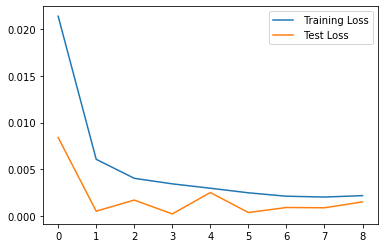

In [32]:
print(model.summary())

plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

In [33]:
predictions = model.predict(x_test_2)

predicted_price = ms2.inverse_transform(predictions)

predicted_price

2022-05-13 07:56:25.834602: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_31161' and '__inference_standard_lstm_31161_specialized_for_sequential_1_lstm_6_StatefulPartitionedCall_at___inference_distributed_function_31934' both implement 'lstm_43c876a5-9f53-4f15-b88e-5197308bd35a' but their signatures do not match.


array([[1857.1208],
       [1843.3425],
       [1847.7441],
       [1850.2891],
       [1851.9597],
       [1864.7997],
       [1862.2245],
       [1864.8229],
       [1865.6979],
       [1864.0271],
       [1865.1414],
       [1860.1736],
       [1863.8087],
       [1846.2952],
       [1842.2991],
       [1842.3396],
       [1843.0336],
       [1840.783 ],
       [1839.7986],
       [1841.5543],
       [1864.3485],
       [1864.6232],
       [1865.7799],
       [1866.6035],
       [1865.2172],
       [1863.7524],
       [1851.6543],
       [1862.4719],
       [1864.9824],
       [1852.3463],
       [1851.8885],
       [1844.7218],
       [1836.5302],
       [1785.4047],
       [1784.7787],
       [1786.1665],
       [1789.8894],
       [1798.0873],
       [1794.2507],
       [1798.2251],
       [1813.7118],
       [1835.1687],
       [1832.242 ],
       [1830.0417],
       [1826.7075],
       [1828.6399],
       [1832.298 ],
       [1845.7496],
       [1836.9366],
       [1830.5885],


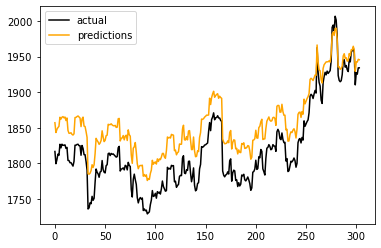

In [34]:
plt.plot(pd.DataFrame(y_test_reshape).reset_index(drop=True),color='black',label='actual')

plt.plot(pd.DataFrame(predicted_price).reset_index(drop=True),color='orange',label='predictions')

plt.legend()

It seems that our model is over predicting the price of gold at the 11th candle

In [35]:
pred_df = pd.DataFrame(y_test_reshape).reset_index(drop=True)

pred_df = pd.concat([pred_df,pd.DataFrame(predicted_price).reset_index(drop=True)], axis=1)

pred_df.columns=['actual','pred']

pred_df['diff'] = pred_df['pred'] - pred_df['actual']

pred_df

,actual,pred,diff
0,1816.685,1857.120850,40.435850
1,1799.500,1843.342529,43.842529
2,1805.210,1847.744141,42.534141
3,1812.940,1850.289062,37.349062
4,1811.335,1851.959717,40.624717
...,...,...,...
299,1910.340,1929.338257,18.998257
300,1927.520,1942.808716,15.288716
301,1925.356,1942.374146,17.018146
302,1934.285,1946.242188,11.957187


<AxesSubplot:title={'center':'diffference between predicted and actual'}>

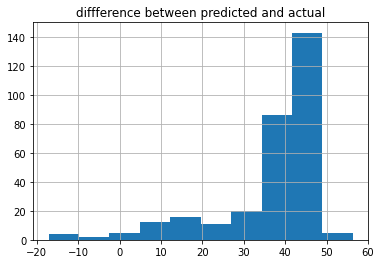

In [36]:
plt.title('diffference between predicted and actual')

pred_df['diff'].hist()

We can see that our model overpredicts the price of gold, as the mode difference is $40-50 in excess

In [37]:
# Now we want to prepare out data for backtesting
# we will only take the events that have candles i.e. those that happen during market trading hours

index_list=[]

for i in range(0,len(event_df)):
    if event_df['candles'][i].shape[0]>10:
        index_list.append(i)

In [38]:
# defining the df for validation and filtering out only relevant predictions that are during market hours
valid_event_df = event_df.loc[index_list][(len(y_train_reshape)):]
pred_df.index = valid_event_df.index
valid_event_df

,day_of_week,event_date_time,event_time_holder,curr,impact,event,previous,forecast,actual,candles
2734,Thu,2021-07-08 20:30:00+08:00,13:30,USD,medium,Unemployment Claims,371K,345K,373K,time volume ...
2735,Thu,2021-07-08 23:00:00+08:00,16:00,USD,medium,Crude Oil Inventories,-6.7M,-4.0M,-6.9M,time volume ...
2736,Mon,2021-07-13 01:01:00+08:00,18:01,USD,medium,10-y Bond Auction,1.50|2.6,,1.37|2.4,time volume ...
2737,Tue,2021-07-13 20:30:00+08:00,13:30,USD,high,CPI m/m,0.6%,0.5%,0.9%,time volume ...
2738,Tue,2021-07-14 01:01:00+08:00,18:01,USD,medium,30-y Bond Auction,2.17|2.3,,2.00|2.2,time volume ...
...,...,...,...,...,...,...,...,...,...,...
3033,Tue,2022-03-29 22:00:00+08:00,15:00,USD,high,JOLTS Job Openings,11.28M,11.00M,11.27M,time volume ...
3034,Wed,2022-03-30 20:15:00+08:00,13:15,USD,high,ADP Non-Farm Employment Change,486K,455K,455K,time volume ...
3035,Wed,2022-03-30 20:30:00+08:00,13:30,USD,medium,Final GDP q/q,7.0%,7.0%,6.9%,time volume ...
3036,Wed,2022-03-30 22:30:00+08:00,15:30,USD,medium,Crude Oil Inventories,-2.5M,-2.0M,-3.4M,time volume ...


In [39]:
#backtester for lstm

def cerebro_LSTM_pro(max_diff,min_threshold):    
    
    results_columns = ['valid_df_index','time','initial_price','pred_price','decision','end_time','end_price','suc','profit']
    
    # order book is where we log backtest results
    order_book_df = pd.DataFrame(columns = results_columns)

    suc_count = 0
    fail_count = 0
    unfinished_count = 0
    
    for i in valid_event_df.index:
        
        pred_price = pred_df.loc[i]['pred']
        
        #current price is the price just before we enter our trade
        
        current_price = valid_event_df.loc[i].candles['mid_c'].iloc[10]
        
        #entry long/short price is when we enter the trade, this is the price we going to get
        entry_long_price = valid_event_df.loc[i].candles['ask_o'].iloc[11]
        entry_short_price = valid_event_df.loc[i].candles['bid_o'].iloc[11]
        event_time = valid_event_df.loc[i].candles.iloc[0].time

        difference_long = abs(pred_price - entry_long_price)
        
        # for risk management purposes, we may want to limit our tp and sl levels
        # if it exceeds the risk we willing to take, defined as max_diff here, we will set the tp/sl to the max diff
        #\n that we can accept
        
        if difference_long>max_diff:
            difference_long = max_diff

        difference_short = abs(pred_price - entry_short_price)

        if difference_short>max_diff:
            difference_short = max_diff
        
        # setting long tp/sl prices
        long_tp_price = entry_long_price + (difference_long)

        long_sl_price = entry_long_price - (difference_long)

        short_tp_price = entry_short_price - (difference_short)

        short_sl_price = entry_short_price + (difference_short)

        # if we predict a higher price than current price, we will long and decision is 1
        if pred_price>current_price:
            decision = 1

        elif pred_price<current_price:
            decision = -1
        
        # if price is exactly the same, we will not trade
        else: 
            print(i)
            pass
        
        #extracting candles for each trade for validation
        
        candles_df_2 = valid_event_df.loc[i].candles[11:]
        
        
        if decision == 1:
            
            #threshold is the minimum difference between our trade and initial price.
            #this is one of our parameters for optimization, where if the difference falls below a certain threshold,
            #\n we may choose not to carry out the trade
            
            if difference_long>=min_threshold:
                for y in candles_df_2.index:
                    
                    if y == candles_df_2.index[-1]:
                        
                        # the candles that we have may not fully complete all the tp and sl. If that's the case,
                        #\n we will close the trade at the end of 20 days and record profit/loss
                        
                        suc_price = candles_df_2.loc[y]['bid_c']

                        end_time = candles_df_2.loc[y]['time']

                        profit = suc_price - entry_long_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_long_price,pred_price,decision,end_time,suc_price,2,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        unfinished_count+=1

                        break
                        
                    elif candles_df_2.loc[y]['bid_l']<=long_sl_price:
                        
                        # if bid low lower than our long sl price, we will record the trade as a loss

                        fail_price = candles_df_2.loc[y]['bid_l']

                        end_time = candles_df_2.loc[y]['time']

                        profit = long_sl_price - entry_long_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_long_price,pred_price,decision,end_time,fail_price,0,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        fail_count +=1

                        break

                    elif candles_df_2.loc[y]['bid_h']>=long_tp_price:
                        
                        # if bid high higher than our long tp price, we will record the trade as a suc

                        suc_price = candles_df_2.loc[y]['bid_h']

                        end_time = candles_df_2.loc[y]['time']

                        profit = long_tp_price - entry_long_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_long_price,pred_price,decision,end_time,suc_price,1,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        suc_count +=1

                        break

        if decision == -1:

            if difference_short>=min_threshold:

                for y in candles_df_2.index:

                    if y == candles_df_2.index[-1]:

                        suc_price = candles_df_2.loc[y]['ask_c']

                        end_time = candles_df_2.loc[y]['time']

                        profit = entry_short_price - suc_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_short_price,pred_price,decision,end_time,suc_price,2,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        unfinished_count+=1

                        break
                        
                    elif candles_df_2.loc[y]['ask_h']>=short_sl_price:
                        
                        # if ask high higher than our short sl price, we will record the trade as a loss

                        fail_price = candles_df_2.loc[y]['ask_h']

                        end_time = candles_df_2.loc[y]['time']

                        profit = entry_short_price - short_sl_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_short_price,pred_price,decision,end_time,fail_price,0,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        fail_count +=1

                        break

                    elif candles_df_2.loc[y]['ask_l']<=short_tp_price:
                        
                        # if ask low lower than our short tp price, we will record the trade as a success

                        suc_price = candles_df_2.loc[y]['ask_l']

                        end_time = candles_df_2.loc[y]['time']

                        profit = entry_short_price - short_tp_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_short_price,pred_price,decision,end_time,suc_price,1,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        suc_count +=1

                        break

    print (f'suc_count: {suc_count}')
    print (f'fail_count: {fail_count}') 
    print (f'unfinished_count: {unfinished_count}') 
    print (f'suc_percentage: {suc_count/(suc_count+fail_count)}')
    print (f'total_count: {suc_count+fail_count+unfinished_count}')
    print (f'profit: {sum(order_book_df["profit"])}')

    return order_book_df

In [88]:
# running backtester with max risk of $100 per trade and no minimum difference threshold

cerebro_LSTM_pro(100,0)


suc_count: 163
fail_count: 122
unfinished_count: 19
suc_percentage: 0.5719298245614035
total_count: 304
profit: 2475.8941083984373


,valid_df_index,time,initial_price,pred_price,decision,end_time,end_price,suc,profit
0,2734,2021-07-08 20:29:00+08:00,1816.765,1857.120850,1,2021-08-06 20:49:00+08:00,1776.018,0,-40.355850
1,2735,2021-07-08 22:59:00+08:00,1799.620,1843.342529,1,2021-08-07 02:51:00+08:00,1763.606,2,-36.014000
2,2736,2021-07-13 01:00:00+08:00,1805.396,1847.744141,1,2021-08-06 22:39:00+08:00,1762.776,0,-42.348141
3,2737,2021-07-13 20:29:00+08:00,1813.233,1850.289062,1,2021-08-06 20:49:00+08:00,1776.018,0,-37.056063
4,2738,2021-07-14 01:00:00+08:00,1811.433,1851.959717,1,2021-08-06 21:05:00+08:00,1770.835,0,-40.526717
...,...,...,...,...,...,...,...,...,...
299,3033,2022-03-29 21:59:00+08:00,1910.510,1929.338257,1,2022-03-30 20:16:00+08:00,1931.888,1,18.828257
300,3034,2022-03-30 20:14:00+08:00,1927.623,1942.808716,1,2022-03-31 23:25:00+08:00,1943.177,1,15.185716
301,3035,2022-03-30 20:29:00+08:00,1925.474,1942.374146,1,2022-03-31 22:02:00+08:00,1942.603,1,16.900146
302,3036,2022-03-30 22:29:00+08:00,1934.425,1946.242188,1,2022-03-31 12:28:00+08:00,1920.221,0,-11.817188


In [89]:
# running backtester with max risk of $10-$15 per trade and minimum price difference threshold of $3-$6

for i in [10,15]:
    for y in range(3,6):
        print (f' max_diff:{i}, min_threshold: {y}')
        print()
        cerebro_LSTM_pro(i,y)
        print()

 max_diff:10, min_threshold: 3

suc_count: 150
fail_count: 152
unfinished_count: 0
suc_percentage: 0.4966887417218543
total_count: 302
profit: -8.377975585937293

 max_diff:10, min_threshold: 4

suc_count: 150
fail_count: 150
unfinished_count: 0
suc_percentage: 0.5
total_count: 300
profit: -1.2909580078123781

 max_diff:10, min_threshold: 5

suc_count: 148
fail_count: 150
unfinished_count: 0
suc_percentage: 0.4966442953020134
total_count: 298
profit: -10.341666015624924

 max_diff:15, min_threshold: 3

suc_count: 170
fail_count: 132
unfinished_count: 0
suc_percentage: 0.5629139072847682
total_count: 302
profit: 611.8265419921877

 max_diff:15, min_threshold: 4

suc_count: 170
fail_count: 130
unfinished_count: 0
suc_percentage: 0.5666666666666667
total_count: 300
profit: 618.9135595703126

 max_diff:15, min_threshold: 5

suc_count: 168
fail_count: 130
unfinished_count: 0
suc_percentage: 0.5637583892617449
total_count: 298
profit: 609.8628515625



In [90]:
# running backtester with max risk of $15 per trade with varying thresholds
for i in [15]:
    for y in range(6):
        print (f' max_diff:{i}, min_threshold: {y}')
        print()
        cerebro_LSTM_pro(i,y)
        print()

 max_diff:15, min_threshold: 0

suc_count: 171
fail_count: 133
unfinished_count: 0
suc_percentage: 0.5625
total_count: 304
profit: 613.2404921875002

 max_diff:15, min_threshold: 1

suc_count: 171
fail_count: 132
unfinished_count: 0
suc_percentage: 0.5643564356435643
total_count: 303
profit: 613.8411318359376

 max_diff:15, min_threshold: 2

suc_count: 171
fail_count: 132
unfinished_count: 0
suc_percentage: 0.5643564356435643
total_count: 303
profit: 613.8411318359376

 max_diff:15, min_threshold: 3

suc_count: 170
fail_count: 132
unfinished_count: 0
suc_percentage: 0.5629139072847682
total_count: 302
profit: 611.8265419921877

 max_diff:15, min_threshold: 4

suc_count: 170
fail_count: 130
unfinished_count: 0
suc_percentage: 0.5666666666666667
total_count: 300
profit: 618.9135595703126

 max_diff:15, min_threshold: 5

suc_count: 168
fail_count: 130
unfinished_count: 0
suc_percentage: 0.5637583892617449
total_count: 298
profit: 609.8628515625



In [131]:
# We can see that with a max threshold of $100, we are able to gain maximum profit.
order_book_df = cerebro_LSTM_pro(100,0)
order_book_df

suc_count: 163
fail_count: 122
unfinished_count: 19
suc_percentage: 0.5719298245614035
total_count: 304
profit: 2475.8941083984373


,valid_df_index,time,initial_price,pred_price,decision,end_time,end_price,suc,profit
0,2734,2021-07-08 20:29:00+08:00,1816.765,1857.120850,1,2021-08-06 20:49:00+08:00,1776.018,0,-40.355850
1,2735,2021-07-08 22:59:00+08:00,1799.620,1843.342529,1,2021-08-07 02:51:00+08:00,1763.606,2,-36.014000
2,2736,2021-07-13 01:00:00+08:00,1805.396,1847.744141,1,2021-08-06 22:39:00+08:00,1762.776,0,-42.348141
3,2737,2021-07-13 20:29:00+08:00,1813.233,1850.289062,1,2021-08-06 20:49:00+08:00,1776.018,0,-37.056063
4,2738,2021-07-14 01:00:00+08:00,1811.433,1851.959717,1,2021-08-06 21:05:00+08:00,1770.835,0,-40.526717
...,...,...,...,...,...,...,...,...,...
299,3033,2022-03-29 21:59:00+08:00,1910.510,1929.338257,1,2022-03-30 20:16:00+08:00,1931.888,1,18.828257
300,3034,2022-03-30 20:14:00+08:00,1927.623,1942.808716,1,2022-03-31 23:25:00+08:00,1943.177,1,15.185716
301,3035,2022-03-30 20:29:00+08:00,1925.474,1942.374146,1,2022-03-31 22:02:00+08:00,1942.603,1,16.900146
302,3036,2022-03-30 22:29:00+08:00,1934.425,1946.242188,1,2022-03-31 12:28:00+08:00,1920.221,0,-11.817188


In [295]:
#model.save("lstm_model_10")
#model = load_model("lstm_model_10")

2022-05-10 04:49:25.263927: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: lstm_model_10/assets


In [9]:
# Next, we will do a cross validation check. 
# Our model is not sequential as it is meant to model the change in price after each event
# Hence, we will do a cross val where we split the time up into 10 slots, train on 9 slots 
#\n and test on the remaining 1 slot

cross_val_eval = []

def get_model_name(max_diff,min_threshold,cross_val_number):
    model_name = f'lstm_model_{max_diff}_{min_threshold}_{cross_val_number}_cv'
    return model_name

def cerebro_LSTM_cross_val(max_diff,min_threshold,cross_val_number,test_size=0.1):
    
    results = {}
    
    lstm_x_df.reset_index(inplace=True,drop=True)
    lstm_y_df.reset_index(inplace=True,drop=True)
    
    test_len = round(test_size*len(lstm_x_df))
    train_len = len(lstm_x_df) - test_len
    time_steps = lstm_x_df.shape[1]
    
    # defining testing set for each time slot
    
    j = cross_val_number
    
    test_set = lstm_x_df.loc[j*test_len:(j+1)*test_len]
    
    if len(test_set)<test_len:
        
        test_set = lstm_x_df[-test_len:]
    
    # defining training set for each time slot
    
    train_set = lstm_x_df.loc[[x for x in lstm_x_df.index if x not in test_set.index]]
    
    x_train_reshape = np.array(train_set).reshape(-1,1)
    x_test_reshape = np.array(test_set).reshape(-1,1)

    y_train_reshape = lstm_y_df.loc[train_set.index]
    y_test_reshape = lstm_y_df.loc[test_set.index]

    ms = MinMaxScaler()

    ms2 = MinMaxScaler()

    x_train_sc = ms.fit_transform(x_train_reshape)
    x_test_sc = ms.transform(x_test_reshape)

    y_train_sc = ms2.fit_transform(pd.DataFrame(y_train_reshape))
    y_test_sc = ms2.transform(pd.DataFrame(y_test_reshape))

    x_train_2 = np.array(x_train_sc).reshape(int(x_train_reshape.shape[0]/time_steps),time_steps,1)
    x_test_2 = np.array(x_test_sc).reshape(int(x_test_reshape.shape[0]/time_steps),time_steps,1)

    y_train_2 = y_train_sc
    y_test_2 = y_test_sc
    
    tf.random.set_seed(0)

    model= Sequential()

    model.add(LSTM(10,return_sequences=True,input_shape=(10,1)))
    model.add(Dropout(0.2))

    model.add(LSTM(10,return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(10,return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(10,return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    
    model.compile(optimizer='adam',loss='mean_squared_error')

    es = EarlyStopping(patience = 5)

    history = model.fit(x_train_2,y_train_2,validation_data = (x_test_2,y_test_2),epochs=100,
                         batch_size=10, callbacks = [es],verbose = False)
    
    # save model for reference
    model.save(get_model_name(max_diff,min_threshold,cross_val_number))
    
    predictions = model.predict(x_test_2)

    predicted_price = ms2.inverse_transform(predictions)
    
    plt.figure(figsize=(8,6))

    plt.plot(pd.DataFrame(y_test_reshape).reset_index(drop=True),color='black',label='actual')

    plt.plot(pd.DataFrame(predicted_price).reset_index(drop=True),color='orange',label='predictions')
    
    plt.title(f'cross_val: {cross_val_number}, max_diff: {max_diff}, min_threshold: {min_threshold}')
    
    plt.legend()
    
    pred_df = pd.DataFrame(y_test_reshape).reset_index(drop=True)

    pred_df = pd.concat([pred_df,pd.DataFrame(predicted_price).reset_index(drop=True)], axis=1)

    pred_df.columns=['actual','pred']

    pred_df['diff'] = pred_df['pred'] - pred_df['actual']

    index_list=[]

    for k in range(0,len(event_df)):
        if event_df['candles'][k].shape[0]>10:
            index_list.append(k)

    valid_event_df = event_df.loc[index_list].loc[y_test_reshape.index]
    
    pred_df.index = valid_event_df.index
    
    # start of backtester
    
    results_columns = ['valid_df_index','time','initial_price','pred_price','decision','end_time','end_price','suc','profit']

    order_book_df = pd.DataFrame(columns = results_columns)

    suc_count = 0
    fail_count = 0
    unfinished_count = 0

    for i in valid_event_df.index:

        pred_price = pred_df.loc[i]['pred']
        current_price = valid_event_df.loc[i].candles['mid_c'].iloc[9]
        entry_long_price = valid_event_df.loc[i].candles['ask_o'].iloc[10]
        entry_short_price = valid_event_df.loc[i].candles['bid_o'].iloc[10]
        event_time = valid_event_df.loc[i].candles.iloc[0].time

        difference_long = abs(pred_price - entry_long_price)

        if difference_long>max_diff:
            difference_long = max_diff

        difference_short = abs(pred_price - entry_short_price)

        if difference_short>max_diff:
            difference_short = max_diff

        long_tp_price = entry_long_price + (difference_long)

        long_sl_price = entry_long_price - (difference_long)

        short_tp_price = entry_short_price - (difference_short)
        
        short_sl_price = entry_short_price + (difference_short)

        if pred_price>current_price:
            decision = 1

        elif pred_price<current_price:
            decision = -1

        else: 
            print(i)
            pass

        candles_df_2 = valid_event_df.loc[i].candles[10:]

        if decision == 1:
            if difference_long>=min_threshold:
                for y in candles_df_2.index:

                    if y == candles_df_2.index[-1]:

                        suc_price = candles_df_2.loc[y]['bid_c']

                        end_time = candles_df_2.loc[y]['time']

                        profit = suc_price - entry_long_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_long_price,pred_price,decision,end_time,suc_price,2,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        unfinished_count+=1

                        break
                        
                    elif candles_df_2.loc[y]['bid_l']<=long_sl_price:

                        fail_price = candles_df_2.loc[y]['bid_l']

                        end_time = candles_df_2.loc[y]['time']

                        profit = long_sl_price - entry_long_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_long_price,pred_price,decision,end_time,fail_price,0,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        fail_count +=1

                        break

                    elif candles_df_2.loc[y]['bid_h']>=long_tp_price:

                        suc_price = candles_df_2.loc[y]['bid_h']

                        end_time = candles_df_2.loc[y]['time']

                        profit = long_tp_price - entry_long_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_long_price,pred_price,decision,end_time,suc_price,1,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        suc_count +=1

                        break

        if decision == -1:

            if difference_short>=min_threshold:

                for y in candles_df_2.index:

                    if y == candles_df_2.index[-1]:

                        suc_price = candles_df_2.loc[y]['ask_c']

                        end_time = candles_df_2.loc[y]['time']

                        profit = entry_short_price - suc_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_short_price,pred_price,decision,end_time,suc_price,2,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        unfinished_count+=1

                        break
                        
                    elif candles_df_2.loc[y]['ask_h']>=short_sl_price:

                        fail_price = candles_df_2.loc[y]['ask_h']

                        end_time = candles_df_2.loc[y]['time']

                        profit = entry_short_price - short_sl_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_short_price,pred_price,decision,end_time,fail_price,0,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        fail_count +=1

                        break

                    elif candles_df_2.loc[y]['ask_l']<=short_tp_price:

                        suc_price = candles_df_2.loc[y]['ask_l']

                        end_time = candles_df_2.loc[y]['time']

                        profit = entry_short_price - short_tp_price

                        order_book_df = order_book_df.append(pd.Series([i,event_time,entry_short_price,pred_price,decision,end_time,suc_price,1,profit],
                                                                      index= results_columns),
                                                                        ignore_index=True)

                        suc_count +=1

                        break
    
    print(f'max_diff: {max_diff}, min_threshold:{min_threshold}, cross_val_number: {cross_val_number}')
    print (f'suc_count: {suc_count}')
    print (f'fail_count: {fail_count}') 
    print (f'unfinished_count: {unfinished_count}') 
    print (f'suc_percentage: {suc_count/(suc_count+fail_count)}')
    print (f'total_count: {suc_count+fail_count+unfinished_count}')
    print (f'profit: {sum(order_book_df["profit"])}')
    
    results['cross_val_time'] = cross_val_number
    results['start_time'] = valid_event_df.iloc[0]['event_date_time'].date()
    results['end_time'] = valid_event_df.iloc[-1]['event_date_time'].date()
    results['max_diff'] = max_diff
    results['min_threshold'] = min_threshold
    results['loss'] = round(np.min(history.history['loss']),5)
    results['val_loss'] = round(np.min(history.history['val_loss']),5)
    results['suc_count'] = suc_count
    results['fail_count'] = fail_count
    results['unfinished_count'] = unfinished_count
    results['suc_percentage'] = suc_count/(suc_count+fail_count)
    results['total_count'] = suc_count+fail_count+unfinished_count
    results['profit'] = sum(order_book_df["profit"])
    
    cross_val_eval.append(results)
    
    return order_book_df

In [ ]:
##order_book_100_0_0to2 = []

##for j in range(3):
##    order_book_df = cerebro_LSTM_cross_val(100,0,j,test_size=0.1)
##    order_book_100_0_0to2.append(order_book_df)
    
##order_book_100_0_0to2_concat = pd.concat(order_book_100_0_0to2)
##order_book_100_0_0to2_concat.to_pickle('./datasets/order_book_100_0_0to2_concat.pkl')

##order_book_100_0_3to6 = []

##for j in range(3,7):
##    order_book_df = cerebro_LSTM_cross_val(100,0,j,test_size=0.1)
##    order_book_100_0_3to6.append(order_book_df)
    
##order_book_100_0_3to6_concat = pd.concat(order_book_100_0_3to6)
##order_book_100_0_3to6_concat.to_pickle('./datasets/order_book_100_0_3to6_concat.pkl')
    
##order_book_100_0_7to9 = []

##for j in range(7,10):
##    order_book_df = cerebro_LSTM_cross_val(100,0,j,test_size=0.1)
##    order_book_100_0_3to6.append(order_book_df)
    
##order_book_100_0_7to9_concat = pd.concat(order_book_100_0_7to9)
##order_book_100_0_7to9_concat.to_pickle('./datasets/order_book_100_0_7to9_concat.pkl')

In [43]:
# loading and concating each cross val order books 
order_book_100_0_0to2_concat = pd.read_pickle('./datasets/order_book_100_0_0to2_concat.pkl')
order_book_100_0_3to6_concat = pd.read_pickle('./datasets/order_book_100_0_3to6_concat.pkl')
order_book_100_0_7to9_concat = pd.read_pickle('./datasets/order_book_100_0_7to9_concat.pkl')

order_book_100_0 = pd.concat([order_book_100_0_0to2_concat,order_book_100_0_3to6_concat,order_book_100_0_7to9_concat])

In [44]:
print(f'time period: {order_book_100_0_0to2_concat.loc[0].iloc[0].time.date()} to {order_book_100_0_0to2_concat.loc[304].iloc[2].time.date()}')
order_book_100_0_0to2_concat['profit'].sum()

time period: 2015-01-02 to 2016-11-24


3331.736516601565

In [45]:
print(f'time period: {order_book_100_0_3to6_concat.loc[0].iloc[0].time.date()} to {order_book_100_0_3to6_concat.loc[304].iloc[3].time.date()}')
order_book_100_0_3to6_concat['profit'].sum()

time period: 2016-11-24 to 2019-09-18


338.19997949218714

In [46]:
print(f'time period: {order_book_100_0_7to9_concat.loc[0].iloc[0].time.date()} to {order_book_100_0_7to9_concat.loc[303].iloc[2].time.date()}')
order_book_100_0_7to9_concat['profit'].sum()

time period: 2019-09-18 to 2022-03-31


5752.710809570314

We can see that our model is profitable for all time periods.

In [45]:
image_0 = Image(url="./CS Images/cv0_100_0.png", width=500, height=500)
image_1 = Image(url="./CS Images/cv1_100_0.png", width=500, height=500)
image_2 = Image(url="./CS Images/cv2_100_0.png", width=500, height=500)
image_3 = Image(url="./CS Images/cv3_100_0.png", width=500, height=500)
image_4 = Image(url="./CS Images/cv4_100_0.png", width=500, height=500)
image_5 = Image(url="./CS Images/cv5_100_0.png", width=500, height=500)
image_6 = Image(url="./CS Images/cv6_100_0.png", width=500, height=500)
image_7 = Image(url="./CS Images/cv7_100_0.png", width=500, height=500)
image_8 = Image(url="./CS Images/cv8_100_0.png", width=500, height=500)
image_9 = Image(url="./CS Images/cv9_100_0.png", width=500, height=500)

In [46]:
print(f'time period: {order_book_100_0_0to2_concat.loc[0].iloc[0].time.date()} to {order_book_100_0_0to2_concat.loc[304].iloc[0].time.date()}')
display(image_0)
print(f'time period: {order_book_100_0_0to2_concat.loc[0].iloc[1].time.date()} to {order_book_100_0_0to2_concat.loc[304].iloc[1].time.date()}')
display(image_1)
print(f'time period: {order_book_100_0_0to2_concat.loc[0].iloc[2].time.date()} to {order_book_100_0_0to2_concat.loc[304].iloc[2].time.date()}')
display(image_2)
print(f'time period: {order_book_100_0_3to6_concat.loc[0].iloc[0].time.date()} to {order_book_100_0_3to6_concat.loc[304].iloc[0].time.date()}')
display(image_3)
print(f'time period: {order_book_100_0_3to6_concat.loc[0].iloc[1].time.date()} to {order_book_100_0_3to6_concat.loc[304].iloc[1].time.date()}')
display(image_4)
print(f'time period: {order_book_100_0_3to6_concat.loc[0].iloc[2].time.date()} to {order_book_100_0_3to6_concat.loc[304].iloc[2].time.date()}')
display(image_5)
print(f'time period: {order_book_100_0_3to6_concat.loc[0].iloc[3].time.date()} to {order_book_100_0_3to6_concat.loc[304].iloc[3].time.date()}')
display(image_6)
print(f'time period: {order_book_100_0_7to9_concat.loc[0].iloc[0].time.date()} to {order_book_100_0_7to9_concat.loc[304].iloc[0].time.date()}')
display(image_7)
print(f'time period: {order_book_100_0_7to9_concat.loc[0].iloc[1].time.date()} to {order_book_100_0_7to9_concat.loc[304].iloc[1].time.date()}')
display(image_8)
print(f'time period: {order_book_100_0_7to9_concat.loc[0].iloc[2].time.date()} to {order_book_100_0_7to9_concat.loc[303].iloc[2].time.date()}')
display(image_9)

time period: 2015-01-02 to 2015-08-05


time period: 2015-08-05 to 2016-03-24


time period: 2016-03-24 to 2016-11-24


time period: 2016-11-24 to 2017-06-27


time period: 2017-06-27 to 2018-02-23


time period: 2018-02-23 to 2018-11-14


time period: 2018-11-14 to 2019-09-18


time period: 2019-09-18 to 2020-07-02


time period: 2020-07-02 to 2021-07-13


time period: 2021-07-08 to 2022-03-31


We can see that depending on when we define the training set, the model tends to overpredict or underpredict the prices. We suspect that there is not enough training points, and hence training on different time periods tends to change the way the model predicts. We can however see that the model does a decent job during the periods 2017-2018, when gold prices were rather stable.

Mean difference in pred and actual: 6.788787726893025


<AxesSubplot:title={'center':'Difference in prediction and actual'}>

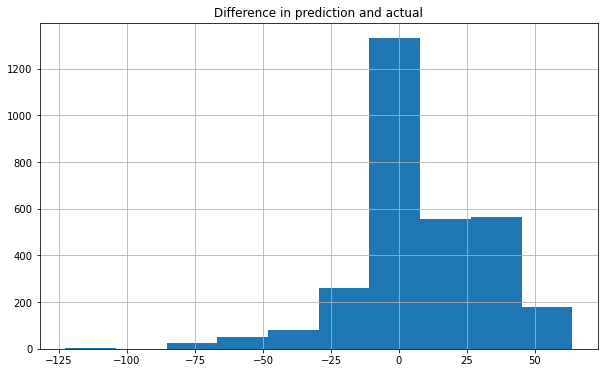

In [47]:
# Let us now look at the mean difference for the prediction and actual

difference_in_pred = order_book_100_0['pred_price'] - order_book_100_0['initial_price']

print(f'Mean difference in pred and actual: {difference_in_pred.mean()}')

plt.figure(figsize = (10,6))
plt.title('Difference in prediction and actual')
difference_in_pred.hist()

We can see that the predicted price is much closer to the actual price, with a mean of $6.70. This means that our model is doing better in terms of accuracy.

In [69]:
event_df.loc[620]

day_of_week                                                        Mon
event_date_time                              2016-04-04 22:00:00+08:00
event_time_holder                                                15:00
curr                                                               USD
impact                                                          medium
event                                               Factory Orders m/m
previous                                                          1.2%
forecast                                                         -1.5%
actual                                                           -1.7%
candles                                          time  volume     m...
Name: 620, dtype: object

In [47]:
#plotting candlesticks for each trade for trade analysis

def plot_trade_candles(event_time,order_book,minutes_after_event,candles_data_df,days_before_event, days_after_event):
    
    order_book = order_book.reset_index()
    
    event_time = astimezone(parse(event_time))
    
    event = event_df[event_df['event_date_time'] == event_time]

    entry = order_book[order_book['time'] == event_time-dt.timedelta(minutes=1)]
    
    event_name = event['event'].iloc[0]
    
    event_time = event['event_date_time'].iloc[0]
    
    # we add a days before and after event so that we can view the full price change before and after event
    
    try:
        
        start_index = candles_data_df[candles_data_df['time']
                           ==(entry['time'].iloc[0]-dt.timedelta(days_before_event))].index[0]
    
        # if there are no candles on the chosen day before/after the event (e.g. saturday), 
        #\n then we expand the window until we find one
    
    except:
        
        try:
            start_index = candles_data_df[candles_data_df['time']
                           ==(entry['time'].iloc[0]-dt.timedelta(days_before_event+1))].index[0]
            
        except:
            start_index = candles_data_df[candles_data_df['time']
                           ==(entry['time'].iloc[0]-dt.timedelta(days_before_event+2))].index[0]
            
    try:

        end_index = candles_data_df[candles_data_df['time']
                       ==(entry['time'].iloc[0]+dt.timedelta(days_after_event))].index[0]
        
    except:
        
        try:
            end_index = candles_data_df[candles_data_df['time']
                           ==(entry['time'].iloc[0]+dt.timedelta(days_after_event+1))].index[0]
            
        except:
            end_index = candles_data_df[candles_data_df['time']
                           ==(entry['time'].iloc[0]+dt.timedelta(days_after_event+2))].index[0]
    
    fig = go.Figure()
    
    plot_candles = candles_data_df.loc[start_index:end_index]
        
    prediction_time = event_time + dt.timedelta(minutes=minutes_after_event)
    pred_price = entry['pred_price'].iloc[0]
    event_price = entry['initial_price'].iloc[0]

    fig.add_trace(go.Candlestick(x=plot_candles.time,
                                open = plot_candles.mid_o,
                                high = plot_candles.mid_h,
                                low = plot_candles.mid_l,
                                close = plot_candles.mid_c,
                                 ))
    
    # event start time indicated with marker
    
    fig.add_trace(
        go.Scatter(x= [event_time],
                    y=[event_price],
                   mode='markers+text+lines',
                   name="Event Time",
                    marker=dict(symbol='triangle-down-open', size = 12, color = 'black')

        )
    )
    
    # the intersection of the pred time and pred price lines shows where the price is supposed to go on our trade time
    
    fig.add_vline(
                             x=prediction_time, 
                             line=dict(color="black",width=1))

    fig.add_hline(
                             y=pred_price, 
                             line=dict(color="black",width=1))

    # This is meant to provide a visual of the trade point to tp/sl point
    
    if entry['decision'].iloc[0] ==1:
        fig.add_trace(go.Scatter(x=[prediction_time,entry['end_time'].iloc[0]], 
                                 y=[event_price,entry['end_price'].iloc[0]],
                        mode='lines',
                        line=dict(color="gold",width=3),name= 'long'))
        
    if entry['decision'].iloc[0] ==-1:
        fig.add_trace(go.Scatter(x=[prediction_time,entry['end_time'].iloc[0]], 
                                 y=[event_price,entry['end_price'].iloc[0]],
                        mode='lines',
                        line=dict(color="orange",width=3),name = 'short',))

    fig.update_layout(width = 850, height = 500, margin = dict(l=10,r=10,t=10,b=10))
    
    fig.update_xaxes(rangebreaks=[dict(bounds=['sat','mon'])])
    
    fig.update_layout(hovermode='x')
    
    fig.update_traces(showlegend=False, selector=dict(type='candlestick'))
    
    display(event)
    display(entry)
    
    print(f'Event: {event_name}, Time: {event_time}')
    
    fig.show()

In [53]:
order_book_100_0[(order_book_100_0['profit']<6) & (order_book_100_0['profit']>5)]

,valid_df_index,time,initial_price,pred_price,decision,end_time,end_price,suc,profit
253,557,2016-02-12 21:29:00+08:00,1233.896,1239.752319,1,2016-02-12 23:00:00+08:00,1240.973,1,5.856319
266,570,2016-02-24 09:29:00+08:00,1225.940,1231.617065,1,2016-02-24 18:04:00+08:00,1231.807,1,5.677065
279,583,2016-03-02 21:14:00+08:00,1229.928,1235.182739,1,2016-03-02 22:25:00+08:00,1235.602,1,5.254739
301,605,2016-03-23 21:59:00+08:00,1217.568,1222.957642,1,2016-03-23 23:56:00+08:00,1223.134,1,5.389642
27,635,2016-04-14 20:29:00+08:00,1236.114,1230.485107,-1,2016-04-14 22:55:00+08:00,1230.423,1,5.628893
28,636,2016-04-14 21:59:00+08:00,1234.175,1228.448242,-1,2016-04-14 23:44:00+08:00,1228.148,1,5.726758
63,671,2016-05-12 22:59:00+08:00,1267.613,1262.594604,-1,2016-05-13 04:45:00+08:00,1262.418,1,5.018396
82,690,2016-05-26 21:59:00+08:00,1225.760,1220.640747,-1,2016-05-27 00:21:00+08:00,1220.561,1,5.119253
262,870,2016-10-20 21:59:00+08:00,1267.606,1261.685059,-1,2016-10-21 15:15:00+08:00,1261.408,1,5.920941
287,895,2016-11-11 22:59:00+08:00,1237.549,1231.703979,-1,2016-11-11 23:11:00+08:00,1231.590,1,5.845021


In [56]:
plot_trade_candles(event_time = '2016-02-24 09:30:00',order_book = order_book_100_0,
                   minutes_after_event = 10,candles_data_df = xau_usd_M1_2015_042822, days_before_event = 3, 
                   days_after_event= 15)

,day_of_week,event_date_time,event_time_holder,curr,impact,event,previous,forecast,actual,candles
583,Wed,2016-03-02 21:15:00+08:00,13:15,USD,high,ADP Non-Farm Employment Change,193K,185K,214K,time volume m...


,index,valid_df_index,time,initial_price,pred_price,decision,end_time,end_price,suc,profit
584,279,583,2016-03-02 21:14:00+08:00,1229.928,1235.182739,1,2016-03-02 22:25:00+08:00,1235.602,1,5.254739


Event: ADP Non-Farm Employment Change, Time: 2016-03-02 21:15:00+08:00


The intersection point shows where out model predicts the price of the 11th candle should be. We can see that our model over predicted the price and the price only hits that target much later.

strat profit: 9422.647305664068


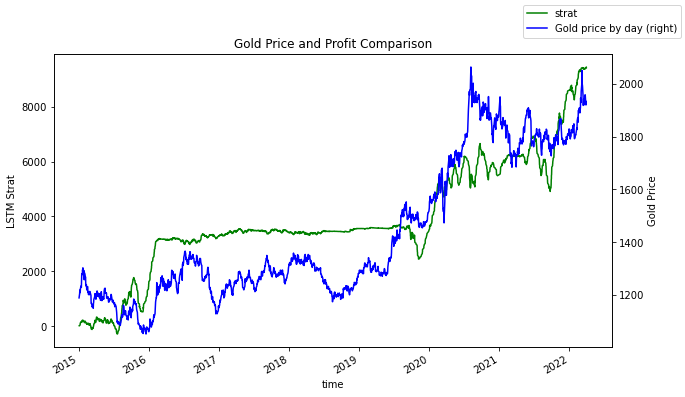

In [496]:
#Let us now compare between our profits and the price of gold t
#\n to see what are the periods where our model was able to achieve profitability

print(f"strat profit: {order_book_100_0['profit'].sum()}")

order_book_100_0_indexed = order_book_100_0.set_index('time')

ts_df = pd.read_pickle('./datasets/XAU_USD_D_010115_300322.pkl')

ts_df['time'] = ts_df['time'].apply(get_utc_dt_from_string)

ts_df['time'] = ts_df['time'].apply(astimezone)

ts_df = ts_df.set_index('time')

plt.figure(figsize = (10,6))

plt.title('Gold Price and Profit Comparison')

order_book_100_0_indexed['profit'].cumsum().plot(label='strat', color = 'g', ylabel='LSTM Strat')

ts_df['mid_c'].plot(label='Gold price by day', color = 'b',secondary_y=True,)

plt.ylabel(ylabel='Gold Price')

plt.figlegend()

plt.show()

We observe that our model manages risk much better than just purely holding gold. During the years of 2016 to 2019, where gold fluctuated, our model actually did not suffer much losses and was mostly even. We do note that our model seems to do better in bull markets. Perhaps this is due to the model's tendency to overpredict as can be seen that the mean difference is an overprediction of $6.70. Let us do some testing to see if we should even short the market.

In [762]:
order_book_100_0_indexed['decision'].value_counts()


 1    1645
-1    1404
Name: decision, dtype: int64

In [756]:
len(order_book_100_0_indexed[order_book_100_0_indexed['profit']>0])/len(order_book_100_0_indexed)


0.5182026894063627

We can see that the number of short and long trades are fairly even.

In [760]:
long_win_perc = len(order_book_100_0_indexed[(order_book_100_0_indexed['decision']==1) & (order_book_100_0_indexed['profit']>0)])/ \
len(order_book_100_0_indexed[order_book_100_0_indexed['decision']==1])

short_win_perc = len(order_book_100_0_indexed[(order_book_100_0_indexed['decision']==-1) & (order_book_100_0_indexed['profit']>0)])/ \
len(order_book_100_0_indexed[order_book_100_0_indexed['decision']==-1])

long_profit = order_book_100_0_indexed[order_book_100_0_indexed['decision']==1]['profit'].sum()
short_profit = order_book_100_0_indexed[order_book_100_0_indexed['decision']==-1]['profit'].sum()


print(f'long_win_perc: {long_win_perc}')
print(f'long_profit: {long_profit}')
print(f'short_win_perc: {short_win_perc}')
print(f'short_profit: {short_profit}')

total_win_perc = len(order_book_100_0_indexed[order_book_100_0_indexed['profit']>0])/len(order_book_100_0_indexed)

total_profit = order_book_100_0_indexed['profit'].sum()

print(f'total_win_perc: {total_win_perc}')
print(f'total_profit: {total_profit}')

long_win_perc: 0.5580547112462007
long_profit: 8532.90788476563
short_win_perc: 0.47150997150997154
short_profit: 889.7394208984383
total_win_perc: 0.5182026894063627
total_profit: 9422.647305664068


When we short, the win percentage was only 47%. However, it is still profitable to short, as we are earning $889 per ounce in total. This means that losses suffered were of smaller magnitude than take profits won. This also means that our winning trades were of higher magnitudes, and that when the model detects a higher jump in price, it is more likely for the trade to be a successful trade.

max drawdown: 2011.813416015627
max drawdown period: 603 days, 1:00:00


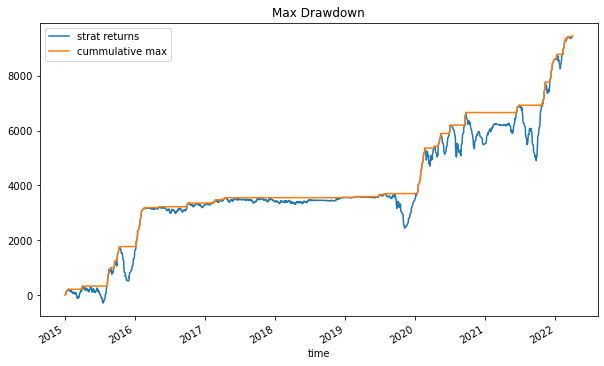

In [371]:
# Calculating Drawdown
drawdown = order_book_100_0_indexed['profit'].cumsum().cummax() - order_book_100_0_indexed['profit'].cumsum()
drawdown.max()

print(f'max drawdown: {drawdown.max()}')

dd_period = (drawdown[drawdown==0].index[1:].to_pydatetime() - drawdown[drawdown==0].index[:-1].to_pydatetime())
dd_period.max()

print(f'max drawdown period: {dd_period.max()}')

plt.figure(figsize=(10,6))

order_book_100_0_indexed['profit'].cumsum().plot(label='strat returns')
order_book_100_0_indexed['profit'].cumsum().cummax().plot(label='cummulative max')

plt.title('Max Drawdown')

plt.legend()

Our max drawdown is \\$2011 and max drawdown period is 603 days. This means that the max loss that we would expect from this strategy at any point in time is \\$2011, and the max number of days that we did not increase our profits is 603 days. We will need to take this into account when we determine our trade size.

In [669]:
# Calculating average holding time per trade

(order_book_100_0_indexed['end_time'] - order_book_100_0_indexed.index).mean()

Timedelta('5 days 01:17:58.228927517')

In [437]:
# Now, we will calculate the recommended trade size and rate of return

base_capital = 10000
leverage = 5 # Oanda provides leverage up to 5 times
total_margin_capital = base_capital*leverage

print(f'total margin capital: {total_margin_capital}')

risk_per_trade = 0.01 # Standard practice is to take up 1% risk of your total capital per trade
risk_per_trade_dollars = total_margin_capital*risk_per_trade
risk_per_trade_dollars

print(f'risk per trade in dollars: {risk_per_trade_dollars}')

risk_per_trade_per_ounce = 100 # This is defined by the sl we will be able to take per trade, 
                                # \n which we have defined in our trading strategy as $100 per ounce
    
ounce_per_trade = risk_per_trade_dollars/risk_per_trade_per_ounce

print(f'Ounce per trade: {ounce_per_trade}')

total margin capital: 50000
risk per trade in dollars: 500.0
Ounce per trade: 5.0


However, we should note that our strategy has a max drawdown of \\$2011 per ounce. Oanda allows a minimum maintenance margin of 50%. For an average of 5 holding days per trade, we may be required to hold 5 trades at any point in time.
With 5 ounce per trade,we will need to maintain a capital of 5* 5* 2000= \\$50,000. However, this is not possible as we may suffer a drawdown of 5* 5* 2011 = $50,275, essentially wiping out our whole capital. Hence, we will need to lower our ounce per trade.

In [452]:
ounce_per_trade = 2

max_drawdown = 2011* ounce_per_trade

remaining_capital = base_capital- max_drawdown

print(f'remaining capital after max dd : {remaining_capital}')

max_remaining_margin = remaining_capital*leverage

print(f'max remaining margin to trade:{max_remaining_margin}')

# assuming max trades held at any point in time is 5

estimated_price_of_gold_per_ounce = 2000

max_trades_held = 5

max_capital_needed = 2 * max_trades_held * estimated_price_of_gold_per_ounce

print(f'max capital needed to hold trades: {max_capital_needed}')

remaining capital after max dd : 5978
max remaining margin to trade:29890
max capital needed to hold trades: 20000


As our max remaining margin is more than our estimated max capital needed to hold the trades, at all points in time,
2 ounce per trade is a suitable trade size. Next, we will calculate the rate of return.

In [492]:
# daily financing cost is the cost of holding overnight trades.
# as our average holding time is 5, we may need to hold over the weekend, which will result in 7 days overnight charge.

daily_financing_cost_per_ounce = 0.1

financing_cost_per_trade = daily_financing_cost_per_ounce* ounce_per_trade

total_holding_days = (order_book_100_0_indexed['end_time'] - order_book_100_0_indexed.index).sum().days

daily_financing = financing_cost_per_trade*total_holding_days

print(f'total daily financing paid: {daily_financing}')

total daily financing paid: 3082.0


In [672]:
profit_per_ounce = order_book_100_0_indexed['profit'].sum()
gross_profit = profit_per_ounce*ounce_per_trade
net_profit = gross_profit - daily_financing

# our time period for total testing period is about 7.25 years from 2015 - 2022 March

time_period = 7.25
profit_per_year = net_profit/time_period
rate_of_return_per_year = profit_per_year/base_capital

print(f'Rate of return per year: {round(rate_of_return_per_year*100,1)}%')

Rate of return per year: 21.7%


We have calculated our estimated profitability to be 21.7% per year. We will next build a trading bot to run this strategy in the next notebook.

In [ ]:
## Backtester for future finetuning

cross_val_eval = []

def get_model_name(max_diff,min_threshold,cross_val_number,epoch_times):
    model_name = f'lstm_model_{max_diff}_{min_threshold}_{cross_val_number}cv_{epoch_times}epoch'
    return model_name

def train_and_save(cross_val_number, epoch_times,max_diff,min_threshold,reload = False):
    
    units = 64
    dense = 0
    
    def create_model():
        
        tf.random.set_seed(0)

        model= Sequential()

        model.add(LSTM(64,return_sequences=True,input_shape=(10,1)))
        model.add(Dropout(0.2))

        model.add(LSTM(64,return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(64,return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(64,return_sequences=False))
        model.add(Dropout(0.2))
        
        #model.add(Dense(units=32))

        model.add(Dense(units=1))

        model.compile(optimizer='adam',loss='mean_squared_error')

        return model
    
    lstm_x_df.reset_index(inplace=True,drop=True)
    lstm_y_df.reset_index(inplace=True,drop=True)
    
    test_len = round(test_size*len(lstm_x_df))
    train_len = len(lstm_x_df) - test_len
    time_steps = lstm_x_df.shape[1]
    
    # defining testing set for each time slot
    
    j = cross_val_number
    
    test_set = lstm_x_df.loc[j*test_len:(j+1)*test_len]
    
    if len(test_set)<test_len:
        
        test_set = lstm_x_df[-test_len:]
    
    # defining training set for each time slot
    
    train_set = lstm_x_df.loc[[x for x in lstm_x_df.index if x not in test_set.index]]
    
    x_train_reshape = np.array(train_set).reshape(-1,1)
    x_test_reshape = np.array(test_set).reshape(-1,1)

    y_train_reshape = lstm_y_df.loc[train_set.index]
    y_test_reshape = lstm_y_df.loc[test_set.index]

    ms = MinMaxScaler()

    ms2 = MinMaxScaler()

    x_train_sc = ms.fit_transform(x_train_reshape)
    x_test_sc = ms.transform(x_test_reshape)

    y_train_sc = ms2.fit_transform(pd.DataFrame(y_train_reshape))
    y_test_sc = ms2.transform(pd.DataFrame(y_test_reshape))

    x_train_2 = np.array(x_train_sc).reshape(int(x_train_reshape.shape[0]/time_steps),time_steps,1)
    x_test_2 = np.array(x_test_sc).reshape(int(x_test_reshape.shape[0]/time_steps),time_steps,1)

    y_train_2 = y_train_sc
    y_test_2 = y_test_sc
    
    # run epochs twice
    for m in epoch_times:
        
        results = {}

        checkpoint_path = f"./checkpoints/cp_{cross_val_number}cv.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)
        ##print(checkpoint_dir)

        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path, 
            verbose=1, 
            save_weights_only=True,
            save_freq=20*len(x_train_2),
            monitor='val_loss',
            mode='min'
        )
        
        model = create_model()        

        if reload == True:
            latest_weights = tf.train.latest_checkpoint(checkpoint_dir)
            latest_weights = checkpoint_path
            model.load_weights(latest_weights)
            val_loss = model.evaluate(x_test_2, y_test_2, verbose=2)
            print("val_loss:", val_loss*100)
        
#         if reload == True:
            
#              model = load_model(f'lstm_cross_val_9_loaded')
        
        history = model.fit(x_train_2, 
                  y_train_2,  
                  epochs=100,
                  validation_data=(x_test_2, y_test_2),
                    callbacks=[cp_callback]
                           )
        
        model.save(get_model_name(max_diff,min_threshold,cross_val_number,epoch_times))
        
        predictions = model.predict(x_test_2)

        predicted_price = ms2.inverse_transform(predictions)

        plt.figure(figsize=(8,6))

        plt.plot(pd.DataFrame(y_test_reshape).reset_index(drop=True),color='black',label='actual')

        plt.plot(pd.DataFrame(predicted_price).reset_index(drop=True),color='orange',label='predictions')

        plt.title(f'cross_val: {cross_val_number}, max_diff: {max_diff}, min_threshold: {min_threshold}, epoch: {m}')

        plt.legend()

        pred_df = pd.DataFrame(y_test_reshape).reset_index(drop=True)

        pred_df = pd.concat([pred_df,pd.DataFrame(predicted_price).reset_index(drop=True)], axis=1)

        pred_df.columns=['actual','pred']

        pred_df['diff'] = pred_df['pred'] - pred_df['actual']

        index_list=[]

        for k in range(0,len(event_df)):
            if event_df['candles'][k].shape[0]>10:
                index_list.append(k)

        valid_event_df = event_df.loc[index_list].loc[y_test_reshape.index]

        pred_df.index = valid_event_df.index

        # start of backtester

        results_columns = ['valid_df_index','time','initial_price','pred_price','decision','end_time','end_price','epoch','units/dense','suc','profit']

        order_book_df = pd.DataFrame(columns = results_columns)

        suc_count = 0
        fail_count = 0
        unfinished_count = 0

        for i in valid_event_df.index:

            pred_price = pred_df.loc[i]['pred']
            current_price = valid_event_df.loc[i].candles['mid_c'].iloc[9]
            entry_long_price = valid_event_df.loc[i].candles['ask_o'].iloc[10]
            entry_short_price = valid_event_df.loc[i].candles['bid_o'].iloc[10]
            event_time = valid_event_df.loc[i].candles.iloc[0].time

            difference_long = abs(pred_price - entry_long_price)

            if difference_long>max_diff:
                difference_long = max_diff

            difference_short = abs(pred_price - entry_short_price)

            if difference_short>max_diff:
                difference_short = max_diff

            long_tp_price = entry_long_price + (difference_long)

            long_sl_price = entry_long_price - (difference_long)

            short_tp_price = entry_short_price - (difference_short)

            short_sl_price = entry_short_price + (difference_short)

            if pred_price>current_price:
                decision = 1

            elif pred_price<current_price:
                decision = -1

            else: 
                print(i)
                pass

            candles_df_2 = valid_event_df.loc[i].candles[10:]

            if decision == 1:
                if difference_long>=min_threshold:
                    for y in candles_df_2.index:

                        if y == candles_df_2.index[-1]:

                            suc_price = candles_df_2.loc[y]['bid_c']

                            end_time = candles_df_2.loc[y]['time']

                            profit = suc_price - entry_long_price

                            order_book_df = order_book_df.append(pd.Series([i,event_time,entry_long_price,pred_price,decision,end_time,suc_price,m,f'{units}/{dense}',2,profit],
                                                                          index= results_columns),
                                                                            ignore_index=True)

                            unfinished_count+=1

                            break

                        elif candles_df_2.loc[y]['bid_l']<=long_sl_price:

                            fail_price = candles_df_2.loc[y]['bid_l']

                            end_time = candles_df_2.loc[y]['time']

                            profit = long_sl_price - entry_long_price

                            order_book_df = order_book_df.append(pd.Series([i,event_time,entry_long_price,pred_price,decision,end_time,fail_price,m,f'{units}/{dense}',0,profit],
                                                                          index= results_columns),
                                                                            ignore_index=True)

                            fail_count +=1

                            break

                        elif candles_df_2.loc[y]['bid_h']>=long_tp_price:

                            suc_price = candles_df_2.loc[y]['bid_h']

                            end_time = candles_df_2.loc[y]['time']

                            profit = long_tp_price - entry_long_price

                            order_book_df = order_book_df.append(pd.Series([i,event_time,entry_long_price,pred_price,decision,end_time,suc_price,m,f'{units}/{dense}',1,profit],
                                                                          index= results_columns),
                                                                            ignore_index=True)

                            suc_count +=1

                            break

            if decision == -1:

                if difference_short>=min_threshold:

                    for y in candles_df_2.index:

                        if y == candles_df_2.index[-1]:

                            suc_price = candles_df_2.loc[y]['ask_c']

                            end_time = candles_df_2.loc[y]['time']

                            profit = entry_short_price - suc_price

                            order_book_df = order_book_df.append(pd.Series([i,event_time,entry_short_price,pred_price,decision,end_time,suc_price,m,f'{units}/{dense}',2,profit],
                                                                          index= results_columns),
                                                                            ignore_index=True)

                            unfinished_count+=1

                            break

                        elif candles_df_2.loc[y]['ask_h']>=short_sl_price:

                            fail_price = candles_df_2.loc[y]['ask_h']

                            end_time = candles_df_2.loc[y]['time']

                            profit = entry_short_price - short_sl_price

                            order_book_df = order_book_df.append(pd.Series([i,event_time,entry_short_price,pred_price,decision,end_time,fail_price,m,f'{units}/{dense}',0,profit],
                                                                          index= results_columns),
                                                                            ignore_index=True)

                            fail_count +=1

                            break

                        elif candles_df_2.loc[y]['ask_l']<=short_tp_price:

                            suc_price = candles_df_2.loc[y]['ask_l']

                            end_time = candles_df_2.loc[y]['time']

                            profit = entry_short_price - short_tp_price

                            order_book_df = order_book_df.append(pd.Series([i,event_time,entry_short_price,pred_price,decision,end_time,suc_price,m,f'{units}/{dense}',1,profit],
                                                                          index= results_columns),
                                                                            ignore_index=True)

                            suc_count +=1

                            break
        
        order_book_df.to_pickle(f'order_book_{max_diff}_{min_threshold}_{cross_val_number}cv_{m}epoch_{units}_{dense}.pkl')

        print(f'max_diff: {max_diff}, min_threshold:{min_threshold}, cross_val_number: {cross_val_number}, epoch: {m}')
        print (f'suc_count: {suc_count}')
        print (f'fail_count: {fail_count}') 
        print (f'unfinished_count: {unfinished_count}') 
        print (f'suc_percentage: {suc_count/(suc_count+fail_count)}')
        print (f'total_count: {suc_count+fail_count+unfinished_count}')
        print (f'profit: {sum(order_book_df["profit"])}')

        results['cross_val_time'] = cross_val_number
        results['units/dense'] = f'{units}/{dense}'
        results['epochs'] = m
        results['start_time'] = valid_event_df.iloc[0]['event_date_time'].date()
        results['end_time'] = valid_event_df.iloc[-1]['event_date_time'].date()
        results['max_diff'] = max_diff
        results['min_threshold'] = min_threshold
        results['loss'] = round(np.min(history.history['loss']),5)
        results['val_loss'] = round(np.min(history.history['val_loss']),5)
        results['suc_count'] = suc_count
        results['fail_count'] = fail_count
        results['unfinished_count'] = unfinished_count
        results['suc_percentage'] = suc_count/(suc_count+fail_count)
        results['total_count'] = suc_count+fail_count+unfinished_count
        results['profit'] = sum(order_book_df["profit"])

        cross_val_eval.append(results)
        
        cross_val_df = pd.read_pickle('cross_val_eval_df.pkl')
        
        cross_val_df.append(pd.DataFrame(cross_val_eval)).to_pickle('cross_val_eval_df.pkl')
        
        reload = True

        print (f'cross_val_completed: {cross_val_number, m}')

    return order_book_df

In [ ]:
order_book_df = train_and_save(cross_val_number = 6, epoch_times = [100,200],
                               max_diff = 100,min_threshold = 0, reload = False)

In [ ]:
order_book_df_1 = pd.read_pickle(f'order_book_{100}_{0}_{0}cv_{100}epoch_{64}_{0}.pkl')
order_book_df_1['profit'].sum()

In [ ]:
cross_val_eval_df =  pd.read_pickle('cross_val_eval_df.pkl')
cross_val_eval_df